In [54]:
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import plotly.express as px
import matplotlib.pyplot as plt
from pyzipcode import ZipCodeDatabase

In [55]:
class RoofImóveis():
    """
        A empresa te contratou pois quer saber qual seria os 5 imóveis que
        ela deveria investir e o porquê e quais 5 você não recomendaria o
        investimento de jeito nenhum.
    """

    def __init__(self):
        path = r'../data/kc_house_data.csv'
        
        self.df = pd.read_csv(
            filepath_or_buffer=path,
            date_parser=['date'],
            sep=',',
            decimal='.',
        )

    def convertendo_a_coluna_date_para_o_tipo_datetime(self):
        self.df['date'] = pd.to_datetime(
            arg=self.df['date'],
            format='%Y%m%dT%H%M%S'
        )

    def removendo_ids_duplicados(self):
        self.df = self.df.sort_values(
            by='date',
            ascending=False
        ).drop_duplicates(subset=['id'])

    def transformando_as_colunas_bathrooms_e_floors_em_inteiros(self):
        self.df['bathrooms'] = self.df['bathrooms'].astype(int)
        self.df['floors'] = self.df['floors'].astype(int)

    def criando_a_coluna_city(self):
        zcdb = ZipCodeDatabase()
        city = []

        for zipcode in self.df['zipcode']:
            try:
                zc = zcdb[zipcode]
                city.append(zc.city)
                
            except KeyError:
                if zipcode == 98077:
                    city.append(str('Woodinville'))
                else:
                    city.append(str('nan'))
        
        self.df['city'] = city

    def média_do_valor_do_ft2_por_cidade(self):
        df = self.df[
            [
                'city',
                'price',
                'sqft_lot',
            ]
        ]

        self.df['price_of_ft2'] = df['price_of_ft2_per_city'] = df['price'] / df['sqft_lot']

        df = df[(np.abs(stats.zscore(df['price_of_ft2_per_city'])) < 3)]
        df = df.groupby('city').agg({'price_of_ft2_per_city': 'mean'}).reset_index()

        price_of_ft2_per_city = []

        for city in self.df['city']:
            df_filtrado = df[
                (df['city'] == city)
            ]['price_of_ft2_per_city'].iloc[0]

            price_of_ft2_per_city.append(df_filtrado)

        self.df['price_of_ft2_per_city'] = price_of_ft2_per_city

        df = df.sort_values(
            by='price_of_ft2_per_city',
            ascending=False
        ).head(5)

        # Gráfico de barras:
        fig, axes = plt.subplots(
                        figsize=(19, 10),
                        dpi=300
                    )
        
        bar_colors = ['#ff4093', '#c06ee2', '#ff9e43', '#8870a0', '#d1c8da']

        ax = sns.barplot(
            data=df,
            x="price_of_ft2_per_city",
            y="city",
            palette=bar_colors
        )

        ax.bar_label(
            ax.containers[0],
            fmt='%.0f',
            padding=5,
            color='snow', 
        )
        axes.tick_params(
            axis='y', 
            colors='white'
        )
        plt.rcParams['font.size']=15
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
        axes.set_xlabel('')
        axes.set_ylabel('')

        axes.get_xaxis().set_ticks([])

        plt.show()
        fig.savefig(f'../img/as_5_cidades_com_a_maior_o_valor_do_ft2_por_cidade.png', transparent=True)

    def média_do_tamanho_do_terreno_por_cidade(self):
        df = self.df[
            [
                'city',
                'sqft_lot',
            ]
        ]

        df = df[(np.abs(stats.zscore(df['sqft_lot'])) < 3)]
        df = df.groupby('city').agg({'sqft_lot': 'mean'}).reset_index()

        plot_size_by_city = []

        for city in self.df['city']:
            df_filtrado = df[
                (df['city'] == city)
            ]['sqft_lot'].iloc[0]

            plot_size_by_city.append(df_filtrado)

        self.df['plot_size_by_city'] = plot_size_by_city

        df = df.sort_values(
            by='sqft_lot',
            ascending=False
        ).head(5)

        # Gráfico de barras:
        fig, axes = plt.subplots(
                        figsize=(19, 10),
                        dpi=300
                    )
        
        bar_colors = ['#ff4093', '#c06ee2', '#ff9e43', '#8870a0', '#d1c8da']

        ax = sns.barplot(
            data=df,
            x="sqft_lot",
            y="city",
            palette=bar_colors
        )

        ax.bar_label(
            ax.containers[0],
            fmt='%.0f',
            padding=5,
            color='snow', 
        )
        axes.tick_params(
            axis='y', 
            colors='white'
        )
        plt.rcParams['font.size']=15
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
        axes.set_xlabel('')
        axes.set_ylabel('')

        axes.get_xaxis().set_ticks([])

        plt.show()
        fig.savefig(f'../img/as_5_cidades_com_a_maior_o_tamanho_do_terreno_por_cidade.png', transparent=True)

    def média_de_quantidade_quartos_por_cidade(self):
        df = self.df[
            [
                'city',
                'bedrooms',
            ]
        ]

        df = df[(np.abs(stats.zscore(df['bedrooms'])) < 3)]
        df = df.groupby('city').agg({'bedrooms': 'mean'}).astype(int).reset_index()

        bedrooms_by_city = []

        for city in self.df['city']:
            df_filtrado = df[
                (df['city'] == city)
            ]['bedrooms'].iloc[0]

            bedrooms_by_city.append(df_filtrado)

        self.df['bedrooms_by_city'] = bedrooms_by_city

        # Gráfico de barras:
        fig, axes = plt.subplots(
            figsize=(10, 10),
        )

        ax = sns.barplot(
            data=df, 
            x="bedrooms", 
            y="city",
            palette='crest'
        )

        ax.bar_label(
            ax.containers[0],
            fmt='%.0f',
            padding=2 )
            
        plt.show()

    def média_de_quantidade_banheiros_por_cidade(self):
        df = self.df[
            [
                'city',
                'bathrooms',
            ]
        ]

        df = df[(np.abs(stats.zscore(df['bathrooms'])) < 3)]
        df = df.groupby('city').agg({'bathrooms': 'mean'}).astype(int).reset_index()

        bathrooms_by_city = []

        for city in self.df['city']:
            df_filtrado = df[
                (df['city'] == city)
            ]['bathrooms'].iloc[0]

            bathrooms_by_city.append(df_filtrado)

        self.df['bathrooms_by_city'] = bathrooms_by_city

        # Gráfico de barras:
        fig, axes = plt.subplots(
            figsize=(10, 10),
        )

        ax = sns.barplot(
            data=df, 
            x="bathrooms", 
            y="city",
            palette='crest'
        )

        ax.bar_label(
            ax.containers[0],
            fmt='%.0f',
            padding=2 )
            
        plt.show()

    def grafico_as_5_cidades_com_a_maior_concentração_de_imóveis(self):
        df = self.df[
            [
                'city',
                'id',
            ]
        ]

        df.rename(
            columns = {'id':'count'}, 
            inplace = True
        )

        df = df.groupby('city').count().reset_index()
        df = df.sort_values(
            by='count',
            ascending=False
        ).head(5)

        # Gráfico de barras:
        fig, axes = plt.subplots(
                        figsize=(19, 10),
                        dpi=300
                    )
        
        bar_colors = ['#ff4093', '#c06ee2', '#ff9e43', '#8870a0', '#d1c8da']

        ax = sns.barplot(
            data=df,
            x="count",
            y="city",
            palette=bar_colors
        )

        ax.bar_label(
            ax.containers[0],
            fmt='%.0f',
            padding=5,
            color='snow', 
        )
        axes.tick_params(
            axis='y', 
            colors='white'
        )
        plt.rcParams['font.size']=15
        axes.spines['top'].set_visible(False)
        axes.spines['right'].set_visible(False)
        axes.spines['bottom'].set_visible(False)
        axes.spines['left'].set_visible(False)
        axes.set_xlabel('')
        axes.set_ylabel('')

        axes.get_xaxis().set_ticks([])

        plt.show()
        fig.savefig(f'../img/as_5_cidades_com_a_maior_concentração_de_imóveis.png', transparent=True)

    def filtrando_os_melhores_imóveis(
        self,
        condition_min=5,
        yr_built_min=1980,
        bedrooms_min=1,
        bathrooms_min=1,
        price_max=1000000.0,
    ):

        df = self.df[
            (self.df['price'] / self.df['sqft_lot'] < self.df['price_of_ft2_per_city']) &
            (self.df['condition'] == condition_min) &
            (self.df['yr_built'] >= yr_built_min) &
            (self.df['bedrooms'] >= bedrooms_min) &
            (self.df['bathrooms'] >= bathrooms_min) &
            (self.df['price'] <= price_max)
        ].sort_values(by='price').reset_index()

        self.imóveis_filtrados = df

        print("""
        Filtros:
            condition_min = 5,
            yr_built_min = 1980,
            bedrooms_min = 1,
            bathrooms_min = 1,
            price_max = 1000000.0,
        """)

    def algoritmo_de_rankeamento_dos_melhores_imóveis(self):

        self.rank_dos_imóveis = {}
        cidades_mais_populosas = [
            'Seattle', 
            'Spokane',
            'Tacoma',
            'Vancouver',
            'Bellevue',
            'Kent',
            'Everett',
            'Renton',
            'Federal Way',
            'Spokane Valley',
        ]

        for id in self.imóveis_filtrados['id']:
            self.rank_dos_imóveis[id] = 0

            city = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['city'].iloc[0]

            price_of_ft2 = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['price_of_ft2'].iloc[0]

            price_of_ft2_per_city = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['price_of_ft2_per_city'].iloc[0]

            sqft_lot = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['sqft_lot'].iloc[0]

            plot_size_by_city = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['plot_size_by_city'].iloc[0]

            bedrooms = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['bedrooms'].iloc[0]

            bedrooms_by_city = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['bedrooms_by_city'].iloc[0]

            bathrooms = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['bathrooms'].iloc[0]

            bathrooms_by_city = self.imóveis_filtrados[
                (self.imóveis_filtrados['id'] == id)
            ]['bathrooms_by_city'].iloc[0]


            resultado = (price_of_ft2_per_city - price_of_ft2) / price_of_ft2 * 100

            if city in cidades_mais_populosas:
                self.rank_dos_imóveis[id] += 30

            if resultado > 50:
                self.rank_dos_imóveis[id] += 30

            if sqft_lot > plot_size_by_city:
                self.rank_dos_imóveis[id] += 20 

            if bedrooms > bedrooms_by_city:
                self.rank_dos_imóveis[id] += 10

            if bathrooms > bathrooms_by_city:
                self.rank_dos_imóveis[id] += 10

        print("""
        Valor de cada metrica:
            Localização, top 10 cidades + populosas = 30,
            Valor do ft2 < abaixo da média da cidade = 30
            Tamanho do terreno > que a média da cidade = 20,
            Quartos > que a média da cidade = 10,
            Banheiros > que a média da cidade = 10,
        """)

    def os_5_melhores_imóveis(self):

        notas_ordenadas = sorted(self.rank_dos_imóveis.values(), reverse=True)
        cinco_maiores_notas = notas_ordenadas[:5]

        ids = [k for k, v in self.rank_dos_imóveis.items() if v in cinco_maiores_notas]
        self.ids = ids[:5]

        df = self.df[
            (self.df['id'].isin(self.ids))
        ].sort_values(by='price').reset_index()

        display(
            df[
                [
                    'id',
                    'city',
                    'price',
                    'sqft_lot',
                    # 'price_of_ft2',
                    # 'price_of_ft2_per_city',
                    'condition',
                    'yr_built',
                    'bedrooms',
                    'bathrooms',
                ]
            ]
        )

    def filtrando_os_piores_imóveis(
        self,
        condition_max=2,
        yr_built_max=1980,
    ):

        df = self.df[
            (self.df['price'] / self.df['sqft_lot'] > self.df['price_of_ft2_per_city']) &
            (self.df['condition'] <= condition_max) &
            (self.df['yr_built'] < yr_built_max)
        ].sort_values(by='price').reset_index()

        self.piores_imóveis_filtrados = df

        print("""
        Filtros:
            condition_max = 2,
            yr_built_max = 1980,
        """)

    def algoritmo_de_rankeamento_dos_piores_imóveis(self):

        self.rank_dos_piores_imóveis = {}
        cidades_mais_populosas = [
            'Seattle', 
            'Spokane',
            'Tacoma',
            'Vancouver',
            'Bellevue',
            'Kent',
            'Everett',
            'Renton',
            'Federal Way',
            'Spokane Valley',
        ]

        for id in self.piores_imóveis_filtrados['id']:
            self.rank_dos_piores_imóveis[id] = 0

            city = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['city'].iloc[0]

            price_of_ft2 = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['price_of_ft2'].iloc[0]

            price_of_ft2_per_city = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['price_of_ft2_per_city'].iloc[0]

            sqft_lot = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['sqft_lot'].iloc[0]

            plot_size_by_city = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['plot_size_by_city'].iloc[0]

            bedrooms = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['bedrooms'].iloc[0]

            bedrooms_by_city = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['bedrooms_by_city'].iloc[0]

            bathrooms = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['bathrooms'].iloc[0]

            bathrooms_by_city = self.piores_imóveis_filtrados[
                (self.piores_imóveis_filtrados['id'] == id)
            ]['bathrooms_by_city'].iloc[0]


            resultado = (price_of_ft2_per_city - price_of_ft2) / price_of_ft2 * 100


            if city not in cidades_mais_populosas:
                self.rank_dos_piores_imóveis[id] += 30

            if resultado < -50:
                self.rank_dos_piores_imóveis[id] += 30

            if sqft_lot < plot_size_by_city:
                self.rank_dos_piores_imóveis[id] += 20 

            if bedrooms < bedrooms_by_city:
                self.rank_dos_piores_imóveis[id] += 10

            if bathrooms < bathrooms_by_city:
                self.rank_dos_piores_imóveis[id] += 10

        print("""
        Valor de cada metrica:
            Localização, fora do top 10 cidades + populosas = 30,
            Valor do ft2 > acima da média da cidade = 30,
            Tamanho do terreno < que a média da cidade = 20,
            Quartos < que a média da cidade = 10,
            Banheiros < que a média da cidade = 10,
        """)

    def os_5_piores_imóveis(self):

        notas_ordenadas = sorted(self.rank_dos_piores_imóveis.values(), reverse=True)
        cinco_maiores_notas = notas_ordenadas[:5]

        ids = [k for k, v in self.rank_dos_piores_imóveis.items() if v in cinco_maiores_notas]
        self.os_piores_ids = ids[:5]

        df = self.df[
            (self.df['id'].isin(self.os_piores_ids))
        ].sort_values(
            by='price',
            ascending=False
        ).reset_index()

        display(
            df[
                [
                    'id',
                    'city',
                    'price',
                    'sqft_lot',
                    'price_of_ft2',
                    'price_of_ft2_per_city',
                    'condition',
                    'yr_built',
                    'bedrooms',
                    'bathrooms',
                ]
            ]
        )


if __name__ == '__main__':
    roof_imóveis = RoofImóveis()

In [56]:
roof_imóveis.convertendo_a_coluna_date_para_o_tipo_datetime()

In [57]:
roof_imóveis.removendo_ids_duplicados()

In [58]:
roof_imóveis.transformando_as_colunas_bathrooms_e_floors_em_inteiros()

In [59]:
roof_imóveis.criando_a_coluna_city()

/tmp/ipykernel_11279/39769603.py:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.df['price_of_ft2'] = df['price_of_ft2_per_city'] = df['price'] / df['sqft_lot']


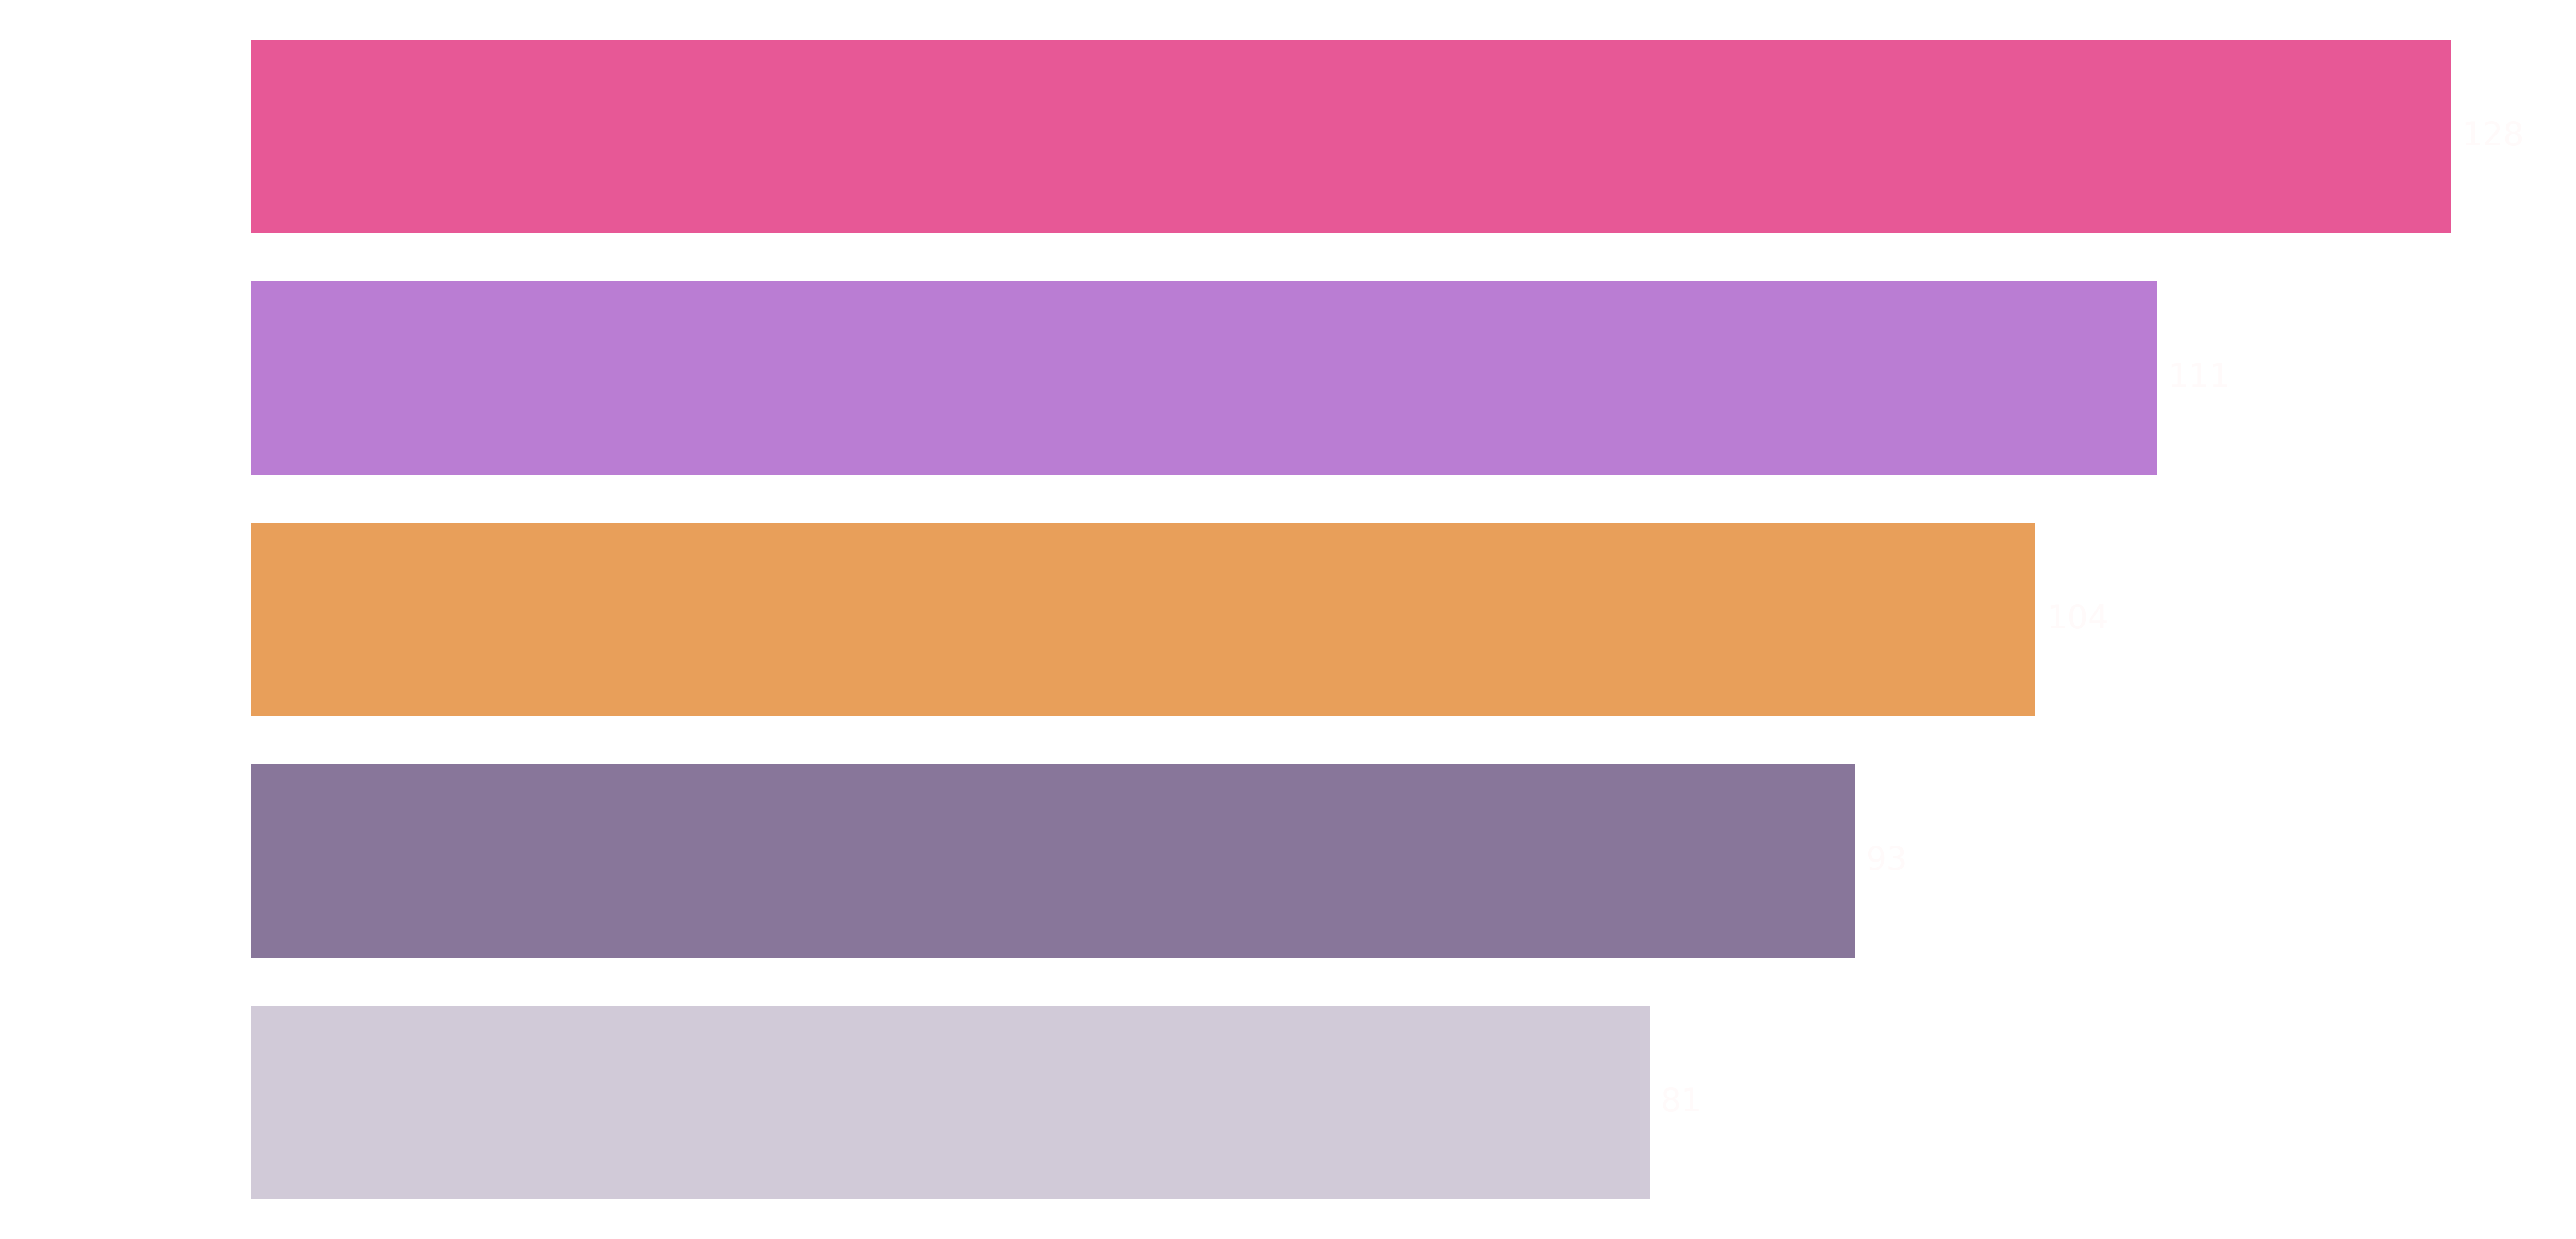

In [60]:
roof_imóveis.média_do_valor_do_ft2_por_cidade()

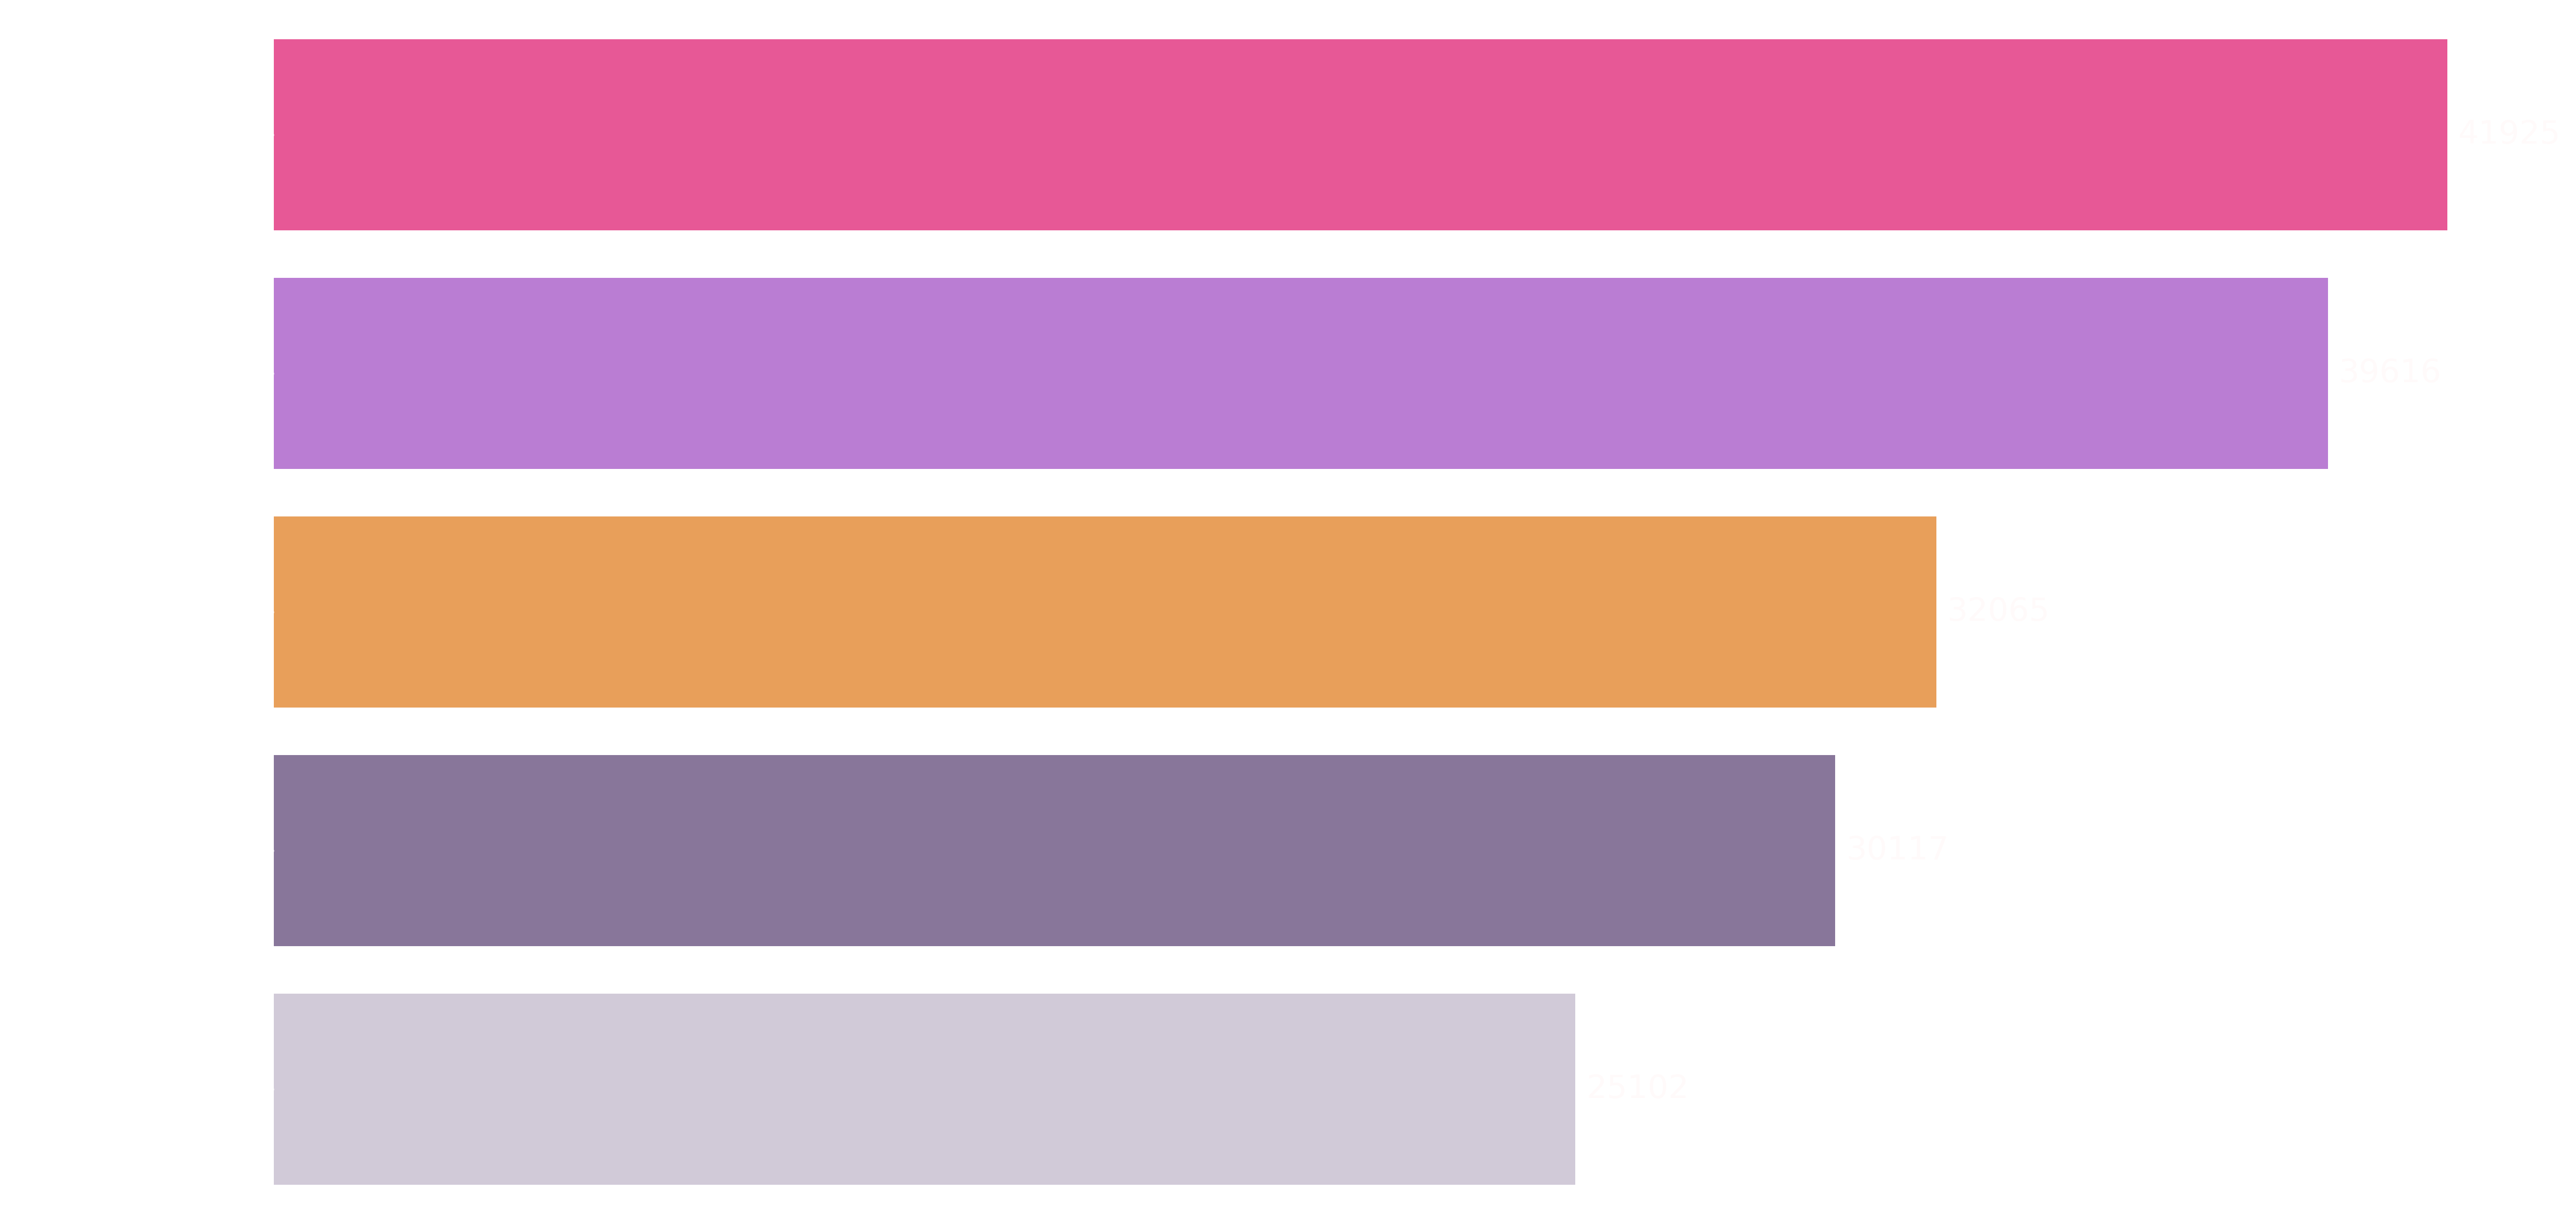

In [61]:
roof_imóveis.média_do_tamanho_do_terreno_por_cidade()

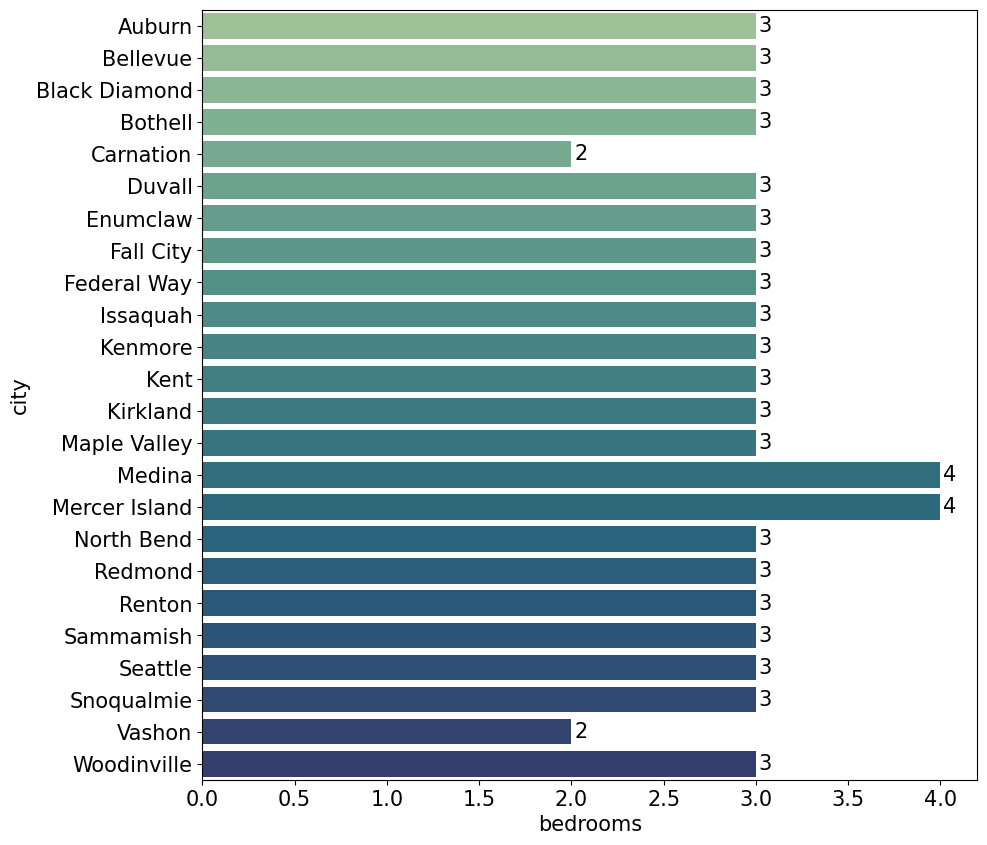

In [62]:
roof_imóveis.média_de_quantidade_quartos_por_cidade()

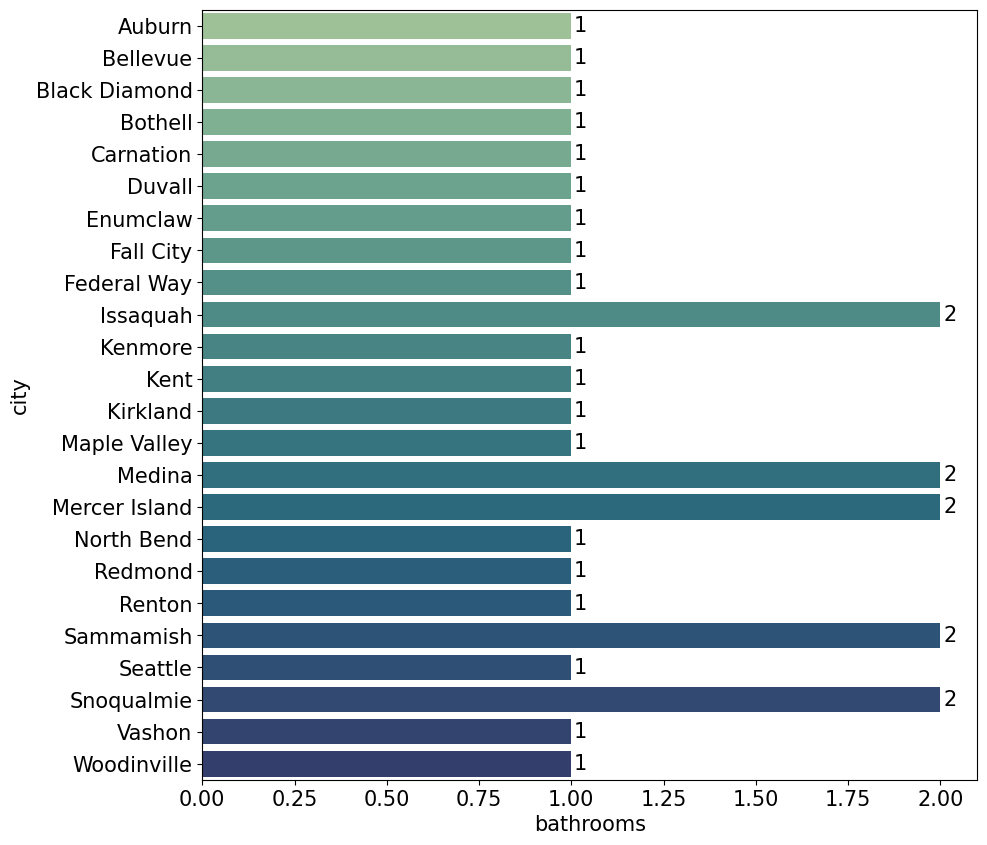

In [63]:
roof_imóveis.média_de_quantidade_banheiros_por_cidade()

/tmp/ipykernel_11279/39769603.py:274: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(


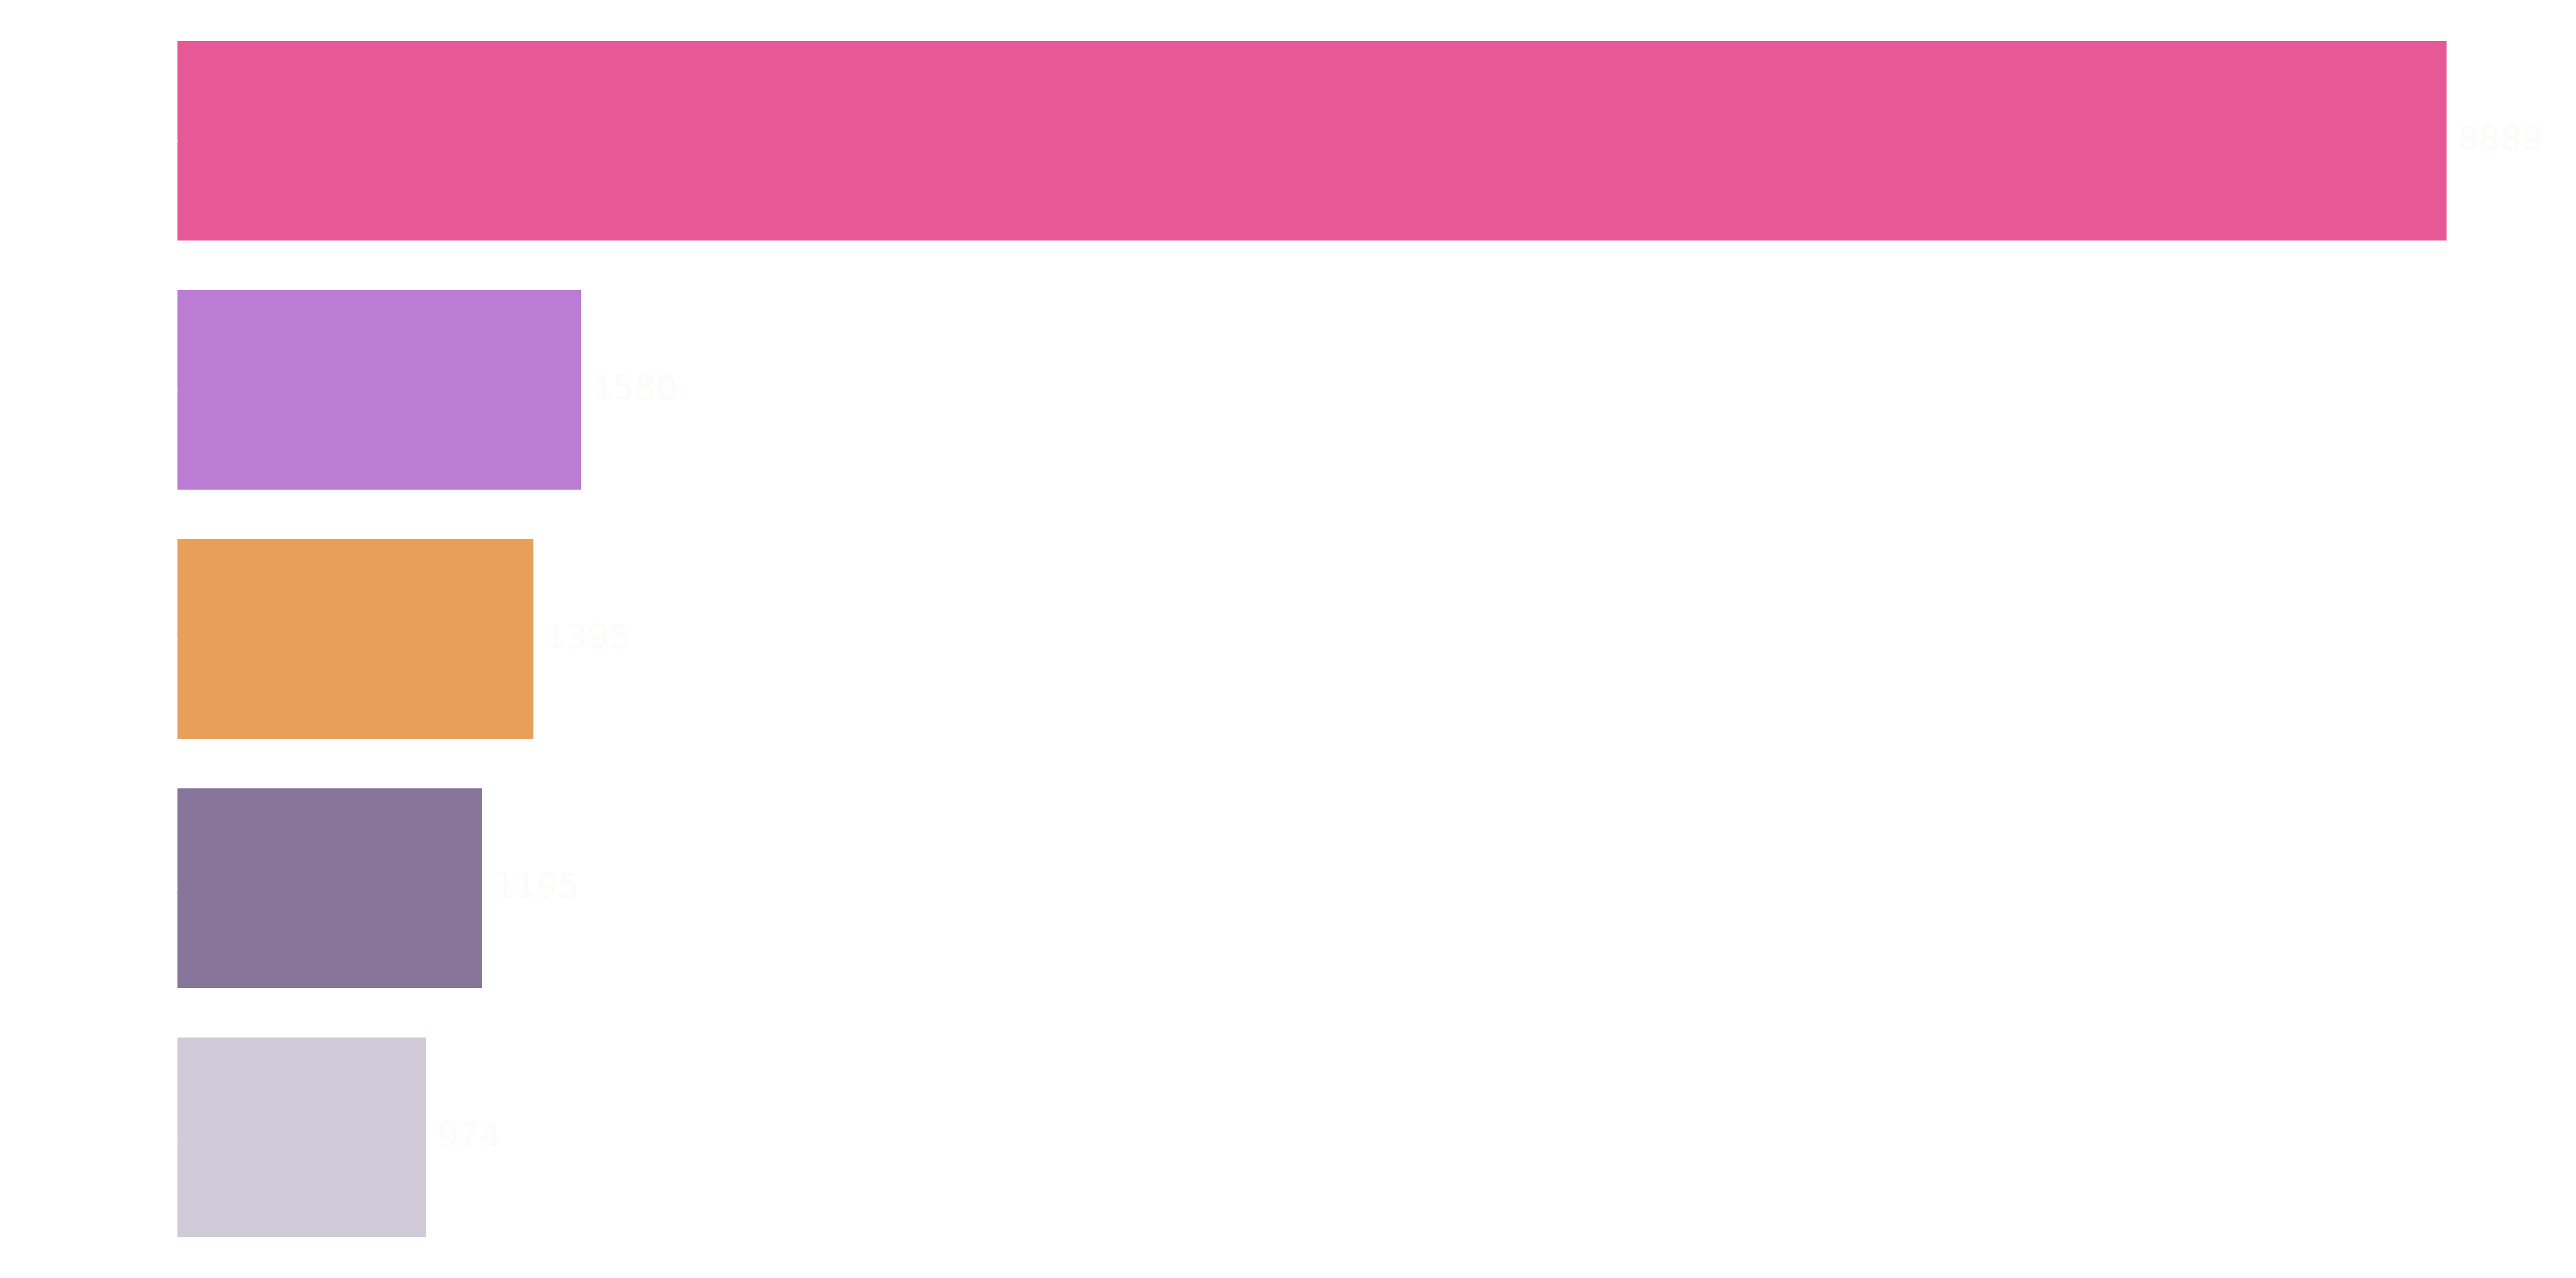

In [64]:
roof_imóveis.grafico_as_5_cidades_com_a_maior_concentração_de_imóveis()

In [65]:
roof_imóveis.filtrando_os_melhores_imóveis()


        Filtros:
            condition_min = 5,
            yr_built_min = 1980,
            bedrooms_min = 1,
            bathrooms_min = 1,
            price_max = 1000000.0,
        


In [66]:
roof_imóveis.algoritmo_de_rankeamento_dos_melhores_imóveis()


        Valor de cada metrica:
            Localização, top 10 cidades + populosas = 30,
            Valor do ft2 < abaixo da média da cidade = 30
            Tamanho do terreno > que a média da cidade = 20,
            Quartos > que a média da cidade = 10,
            Banheiros > que a média da cidade = 10,
        


In [67]:
roof_imóveis.os_5_melhores_imóveis()

,id,city,price,sqft_lot,condition,yr_built,bedrooms,bathrooms
0,2144800146,Seattle,257500.0,9334,5,1981,3,2
1,3348401382,Seattle,318000.0,12662,5,1982,3,2
2,2826049260,Seattle,482500.0,7626,5,1990,4,3
3,4022902715,Seattle,525000.0,10277,5,1993,5,3
4,5067400032,Seattle,550000.0,14400,5,1985,3,2


In [68]:
roof_imóveis.filtrando_os_piores_imóveis()


        Filtros:
            condition_max = 2,
            yr_built_max = 1980,
        


In [69]:
roof_imóveis.algoritmo_de_rankeamento_dos_piores_imóveis()


        Valor de cada metrica:
            Localização, fora do top 10 cidades + populosas = 30,
            Valor do ft2 > acima da média da cidade = 30,
            Tamanho do terreno < que a média da cidade = 20,
            Quartos < que a média da cidade = 10,
            Banheiros < que a média da cidade = 10,
        


In [70]:
roof_imóveis.os_5_piores_imóveis()

,id,city,price,sqft_lot,price_of_ft2,price_of_ft2_per_city,condition,yr_built,bedrooms,bathrooms
0,4083802195,Seattle,578888.0,4000,144.722000,110.916887,2,1914,2,2
1,2028700265,Seattle,505000.0,3816,132.337526,110.916887,2,1929,2,1
2,9407110710,North Bend,322000.0,8400,38.333333,28.573442,2,1979,3,1
3,913000340,Seattle,252000.0,1638,153.846154,110.916887,1,1910,1,1
4,3523029059,Vashon,181000.0,10807,16.748404,15.174456,2,1949,2,1
